In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

import pymatgen

from functions.prepare_data_and_sub import prepare_dataset, make_prediction, energy_within_threshold
from functions.class2_features import unufication_class2, geometrical_features, distance_features
from functions.classification import classificate_class2, classificate_class3, classificate_class4, classificate_class5
from functions.classification import convert_group_to_target_class2, convert_group_to_target_class3, convert_group_to_target_class4, convert_group_to_target_class5
from functions.strusture_analysis import decompose, make_masks, find_differ_sites, extract_ideal_structure

In [2]:
data = prepare_dataset('data/dichalcogenides_public/')
data['decomposition'] = data.structures.apply(decompose)
mask_list = make_masks(data)
ideal_structure_sites = extract_ideal_structure(data)  
data['representative'] = data['structures'].apply(lambda x: find_differ_sites(x.sites, ideal_structure_sites))

  0%|          | 0/380 [00:00<?, ?it/s]

In [3]:
test = prepare_dataset('data/dichalcogenides_private/', train=False)
test['decomposition'] = test.structures.apply(decompose)
mask_list_test = make_masks(test)
test['representative'] = test['structures'].apply(lambda x: find_differ_sites(x.sites, ideal_structure_sites))

test = make_prediction(test, ideal_structure_sites, mask_list_test)

### Class2:

In [4]:
model = DecisionTreeClassifier(max_depth=15, random_state=13)

class2 = data[mask_list[2]].copy()
class2['group'] = class2['targets'].apply(classificate_class2)
class2 = class2[class2.group != 0]

class2 = unufication_class2(class2)
class2 = geometrical_features(class2)

test_class2 = unufication_class2(test[mask_list_test[2]])
test_class2 = geometrical_features(test_class2)

feature_list = ['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']
model.fit(class2[feature_list], class2['group'])

class2_predict_group3 = model.predict(test_class2[feature_list])

/home/polli/IDAO-2022/functions/class2_features.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['representative'] = sample['representative'].apply(lambda x: symmetry_transform_up(x.copy(), x[0].coords))
/home/polli/IDAO-2022/functions/class2_features.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['representative'] = sample['representative'].apply(lambda x: orange_closer(x.copy()))
/home/polli/IDAO-2022/functions/class2_features.py:11: SettingWithCopyWarning: 
A value is trying to be s

In [5]:
class2 = class2[(class2.group == 2) | (class2.group == 1)]

In [6]:
from xgboost import XGBClassifier

feature_list = list(class2.columns[5:])

model = XGBClassifier(n_estimators=45, random_state=0xC0FFEE)
model.fit(class2[feature_list], class2['group'])
class2_predict_group12 = model.predict(test_class2[feature_list])


[17:08:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/polli/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [7]:
class2_predict_group = class2_predict_group12
class2_predict_group[class2_predict_group3 == 3] = 3

predictions_class2 = list(map(convert_group_to_target_class2, class2_predict_group))
test.loc[mask_list_test[2], 'predictions'] = predictions_class2

### Class3:

In [10]:
class3 = data[mask_list[3]].copy()
class3['group'] = class3['targets'].apply(classificate_class3)
class3 = class3[class3.group != 0]
class3 = distance_features(class3)

test_class3 = test[mask_list_test[3]].copy()
test_class3 = distance_features(test_class3)

for i in range(3):
    class3['dist' + str(i+1)] = class3[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)
    test_class3['dist' + str(i+1)] = test_class3[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)
    
feature_list = ['dist1', 'dist2', 'dist3']
model = XGBClassifier(n_estimators=10, random_state=0xC0FFEE)
model.fit(class3[feature_list], class3['group'])

class3_predict_group = model.predict(test_class3[feature_list])

[17:21:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [11]:
predictions_class3 = list(map(convert_group_to_target_class3, class3_predict_group))
test.loc[mask_list_test[3], 'predictions'] = predictions_class3

### Class4

In [37]:
class4 = data[mask_list[4]].copy()
class4['group'] = class4['targets'].apply(classificate_class4)
class4 = class4[class4.group != 0]
class4 = distance_features(class4)

test_class4 = test[mask_list_test[4]].copy()
test_class4 = distance_features(test_class4)

for i in range(3):
    class4['dist' + str(i+1)] = class4[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)
    test_class4['dist' + str(i+1)] = test_class4[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)
    
feature_list = ['dist1', 'dist2', 'dist3']
model = XGBClassifier(n_estimators=5, random_state=0xC0FFEE)
model.fit(class4[feature_list], class4['group'])

class4_predict_group = model.predict(test_class4[feature_list])

[17:28:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [39]:
predictions_class4 = list(map(convert_group_to_target_class4, class4_predict_group))
test.loc[mask_list_test[4], 'predictions'] = predictions_class4

### Class5

In [43]:
class5 = data[mask_list[5]].copy()
class5['group'] = class5['targets'].apply(classificate_class5)
class5 = class5[class5.group != 0]
class5 = distance_features(class5)

test_class5 = test[mask_list_test[5]].copy()
test_class5 = distance_features(test_class5)

for i in range(3):
    class5['dist' + str(i+1)] = class5[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)
    test_class5['dist' + str(i+1)] = test_class5[['Mo_S_dist', 'S_Se_dist', 'Mo_Se_dist']].apply(lambda row: sorted(row)[i], axis=1)
    
feature_list = ['dist1', 'dist2', 'dist3']
model = XGBClassifier(n_estimators=5, random_state=0xC0FFEE)
model.fit(class5[feature_list], class5['group'])

class5_predict_group = model.predict(test_class5[feature_list])

[17:30:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [44]:
predictions_class5 = list(map(convert_group_to_target_class5, class5_predict_group))
test.loc[mask_list_test[5], 'predictions'] = predictions_class5

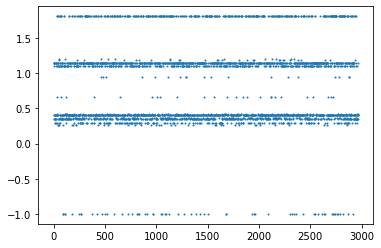

In [47]:
plt.scatter(np.arange(len(test)), test.predictions, s=1)

## Submission

In [48]:
test['predictions'].to_csv('best_submission_in_the_world_6classes.csv')

In [ ]:
# our_submission = test[['predictions']].copy()
# baseline = pd.read_csv('submission.csv', index_col=0)

# unite_sub = our_submission.join(baseline, lsuffix='_our', rsuffix='_bas')
# unite_sub.loc[mask_list_test[0] | mask_list_test[1] | mask_list_test[2], 'predictions'] = unite_sub['predictions_our']
# unite_sub.loc[~(mask_list_test[0] | mask_list_test[1] | mask_list_test[2]), 'predictions'] = unite_sub['predictions_bas']
# unite_sub['predictions'].to_csv('best_submission_in_the_world1_full.csv')